In [68]:
import yfinance as yf
import pandas as pd
from datetime import timedelta
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import json
# Assuming companies variable contains your JSON with publish and effective dates

with open('companies.json', 'r') as file:
    companies = json.load(file)





def calculate_sharpe_ratio(returns, risk_free_rate=0):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    if std_return != 0:
        return (mean_return - risk_free_rate) / std_return
    else:
        return np.nan

def annualize_return(cumulative_return, holding_period_days, periods_per_year=252):
    return (1 + cumulative_return) ** (periods_per_year / holding_period_days) - 1

def annualize_std(cumulative_std, holding_period_days, periods_per_year=252):
    return cumulative_std * np.sqrt(periods_per_year / holding_period_days)

def download_and_align_data(ticker, publish_date):
    publish_date = pd.to_datetime(publish_date)
    start_date = publish_date + pd.DateOffset(1)
    end_date = publish_date + pd.DateOffset(months=6)  # Increased to 6 months to cover longer holding periods
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    if 'Close' not in stock_data.columns or 'Open' not in stock_data.columns:
        raise ValueError(f"Data for {ticker} does not contain 'Close' or 'Open' prices.")
    stock_data = stock_data.reset_index()
    stock_data['Days Since Publish'] = (stock_data['Date'] - stock_data['Date'].iloc[0]).dt.days
    return stock_data[['Date', 'Days Since Publish', 'Open', 'Close']]

def simulate_trade(data, holding_periods):
    tickers = data['Ticker'].unique()
    results = []

    for holding_period in holding_periods:
        returns = []
        for ticker in tickers:
            ticker_data = data[data['Ticker'] == ticker].reset_index(drop=True)
            if len(ticker_data) >= holding_period:
                start_price = ticker_data['Open'].iloc[0]
                end_price = ticker_data['Close'].iloc[holding_period - 1]
                cumulative_return = (end_price - start_price) / start_price
                returns.append(cumulative_return)
        if len(returns) > 0:
            avg_return = np.mean(returns)
            std_deviation = np.std(returns)
            sharpe_ratio = calculate_sharpe_ratio(returns)
            annualized_ret = annualize_return(avg_return, holding_period)
            annualized_std_dev = annualize_std(std_deviation, holding_period)
            annualized_sharpe = annualize_sharpe(annualized_ret, annualized_std_dev)
            results.append({
                'Holding Period': holding_period,
                'Average Return': avg_return,
                'Standard Deviation': std_deviation,
                'Sharpe Ratio': sharpe_ratio,
                'Annualized Return': annualized_ret,
                'Annualized Std Dev': annualized_std_dev,
                'Annualized Sharpe Ratio': annualized_sharpe
            })
    return pd.DataFrame(results)

def annualize_sharpe(annualized_return, annualized_std):
    if annualized_std != 0:
        return annualized_return / annualized_std
    else:
        return np.nan
    
    
def download_intraday_data(ticker, publish_date, interval='1m'):
    publish_date = pd.to_datetime(publish_date)
    
    # Define the start and end time for the publish date
    # Assuming publish_date is the date when the news is released before market opens or during trading hours
    start_datetime = publish_date
    end_datetime = publish_date + timedelta(days=1)
    
    try:
        intraday_data = yf.download(
            ticker,
            start=start_datetime,
            end=end_datetime,
            interval=interval,
            prepost=True,  # Include pre-market and post-market data
            progress=False
        )
        
        if intraday_data.empty:
            raise ValueError(f"No intraday data found for {ticker} on {publish_date.date()}")
        
        # Reset index to have 'Datetime' as a column
        intraday_data = intraday_data.reset_index()
        
        # Add 'Ticker' column for identification
        intraday_data['Ticker'] = ticker
        
        return intraday_data
    except Exception as e:
        print(f"Error fetching intraday data for {ticker} on {publish_date.date()}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on failure



In [69]:

# Download and align data
aligned_data = {}
aligned_data_intraday = {}

for company in companies:
    ticker = company['ticker']
    publish_date = company['publish_date']
    try:
        aligned_data[ticker] = download_and_align_data(ticker, publish_date)
        print(f"Successfully downloaded and aligned data for {ticker}")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")


      # Download intraday data for publish date
    try:
        intraday = download_intraday_data(ticker, publish_date, interval='1h')  # You can change interval if needed
        if not intraday.empty:
            aligned_data_intraday[ticker] = intraday
            print(f"Successfully downloaded intraday data for {ticker} on {publish_date}")
        else:
            print(f"No intraday data for {ticker} on {publish_date}")
    except Exception as e:
        print(f"Error downloading intraday data for {ticker}: {e}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Successfully downloaded and aligned data for SW
Successfully downloaded intraday data for SW on 2024-07-08
Successfully downloaded and aligned data for CRWD
Successfully downloaded intraday data for CRWD on 2024-06-07



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Successfully downloaded and aligned data for KKR
Successfully downloaded intraday data for KKR on 2024-06-07
Successfully downloaded and aligned data for GDDY
Successfully downloaded intraday data for GDDY on 2024-06-07
Successfully downloaded and aligned data for VST
Successfully downloaded intraday data for VST on 2024-05-03


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1711512000, endDate = 1711598400")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1711512000, endDate = 1711598400")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Successfully downloaded and aligned data for GEV
Error fetching intraday data for GEV on 2024-03-27: No intraday data found for GEV on 2024-03-27
No intraday data for GEV on 2024-03-27
Successfully downloaded and aligned data for SOLV
Error fetching intraday data for SOLV on 2024-03-27: No intraday data found for SOLV on 2024-03-27
No intraday data for SOLV on 2024-03-27
Successfully downloaded and aligned data for DECK
Successfully downloaded intraday data for DECK on 2024-03-01
Successfully downloaded and aligned data for SMCI
Successfully downloaded intraday data for SMCI on 2024-03-01
Successfully downloaded and aligned data for BLDR
Successfully downloaded intraday data for BLDR on 2023-12-01



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1695873600, endDate = 1695960000")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Successfully downloaded and aligned data for UBER
Successfully downloaded intraday data for UBER on 2023-12-01
Successfully downloaded and aligned data for JBL
Successfully downloaded intraday data for JBL on 2023-12-01
Successfully downloaded and aligned data for LULU
Successfully downloaded intraday data for LULU on 2023-10-13
Successfully downloaded and aligned data for HUBB
Successfully downloaded intraday data for HUBB on 2023-10-13
Successfully downloaded and aligned data for VLTO
Error fetching intraday data for VLTO on 2023-09-28: No intraday data found for VLTO on 2023-09-28
No intraday data for VLTO on 2023-09-28
Successfully downloaded and aligned data for ABNB
Successfully downloaded intraday data for ABNB on 2023-09-01
Successfully downloaded and aligned data for BX
Successfully downloaded intraday data for BX on 2023-09-01
Successfully downloaded and aligned data for KVUE
Successfully downloaded intraday data for KVUE on 2023-08-09



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GEHC']: Exception('%ticker%: No price data found, symbol may be delisted (1h 2022-12-28 00:00:00 -> 2022-12-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Successfully downloaded and aligned data for PANW
Successfully downloaded intraday data for PANW on 2023-06-02
Successfully downloaded and aligned data for AXON
Successfully downloaded intraday data for AXON on 2023-05-01
Successfully downloaded and aligned data for FICO
Successfully downloaded intraday data for FICO on 2023-03-03
Successfully downloaded and aligned data for BG
Successfully downloaded intraday data for BG on 2023-03-13
Successfully downloaded and aligned data for PODD
Successfully downloaded intraday data for PODD on 2023-03-10
Successfully downloaded and aligned data for GEHC
Error fetching intraday data for GEHC on 2022-12-28: No intraday data found for GEHC on 2022-12-28
No intraday data for GEHC on 2022-12-28
Successfully downloaded and aligned data for STLD
Successfully downloaded intraday data for STLD on 2022-12-19
Successfully downloaded and aligned data for FSLR



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CSGP']: Exception('%ticker%: 1h data not available for startTime=1662091200 and endTime=1662177600. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['INVH']: Exception('%ticker%: 1h data not available for startTime=1662091200 and endTime=1662177600. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:


Successfully downloaded intraday data for FSLR on 2022-12-12
Successfully downloaded and aligned data for ACGL
Successfully downloaded intraday data for ACGL on 2022-10-27
Successfully downloaded and aligned data for TRGP
Successfully downloaded intraday data for TRGP on 2022-10-06
Successfully downloaded and aligned data for EQT
Successfully downloaded intraday data for EQT on 2022-09-23
Successfully downloaded and aligned data for PCG
Successfully downloaded intraday data for PCG on 2022-09-23
Successfully downloaded and aligned data for CSGP
Error fetching intraday data for CSGP on 2022-09-02: No intraday data found for CSGP on 2022-09-02
No intraday data for CSGP on 2022-09-02
Successfully downloaded and aligned data for INVH
Error fetching intraday data for INVH on 2022-09-02: No intraday data found for INVH on 2022-09-02
No intraday data for INVH on 2022-09-02
Successfully downloaded and aligned data for KDP


['KDP']: Exception('%ticker%: 1h data not available for startTime=1654228800 and endTime=1654315200. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ON']: Exception('%ticker%: 1h data not available for startTime=1654228800 and endTime=1654315200. The requested range must be within the last 730 days.')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VICI']: Exception('%ticker%: 1h data not available for startTime=1654228800 and endTime=1654315200. The requested range must be within the last 730 days.')


Error fetching intraday data for KDP on 2022-06-03: No intraday data found for KDP on 2022-06-03
No intraday data for KDP on 2022-06-03
Successfully downloaded and aligned data for ON
Error fetching intraday data for ON on 2022-06-03: No intraday data found for ON on 2022-06-03
No intraday data for ON on 2022-06-03
Successfully downloaded and aligned data for VICI
Error fetching intraday data for VICI on 2022-06-03: No intraday data found for VICI on 2022-06-03
No intraday data for VICI on 2022-06-03


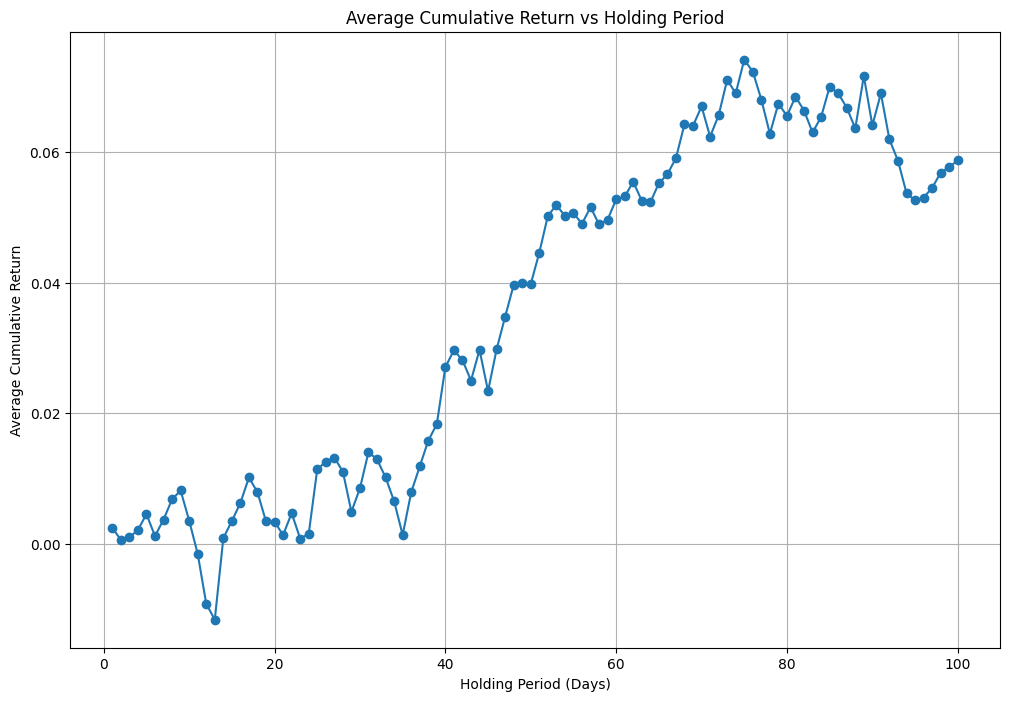

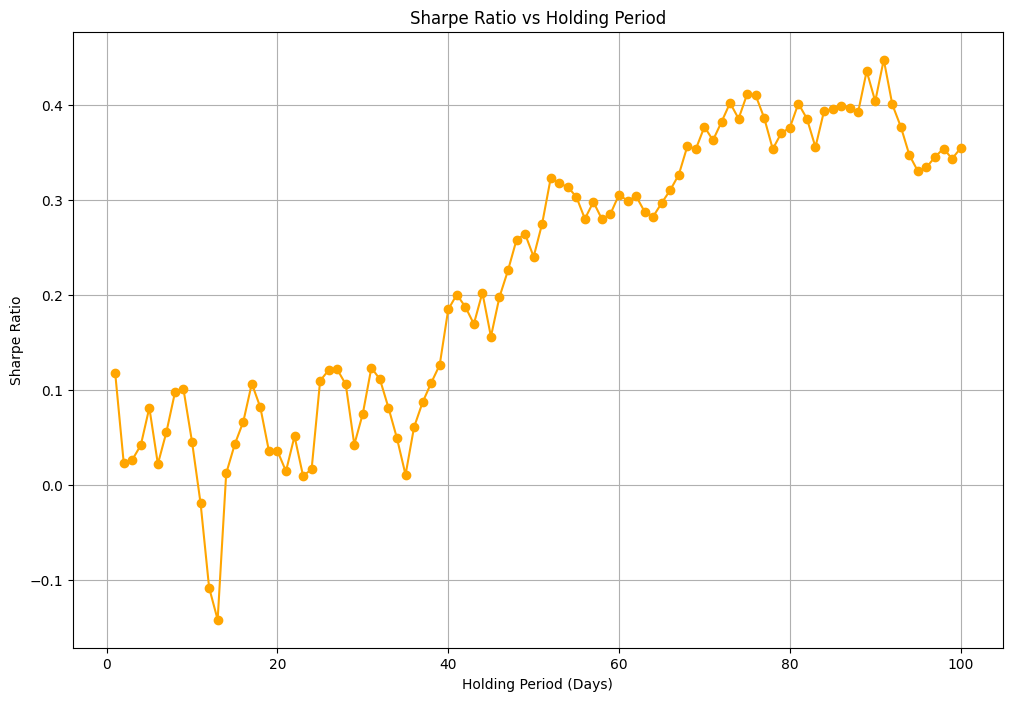

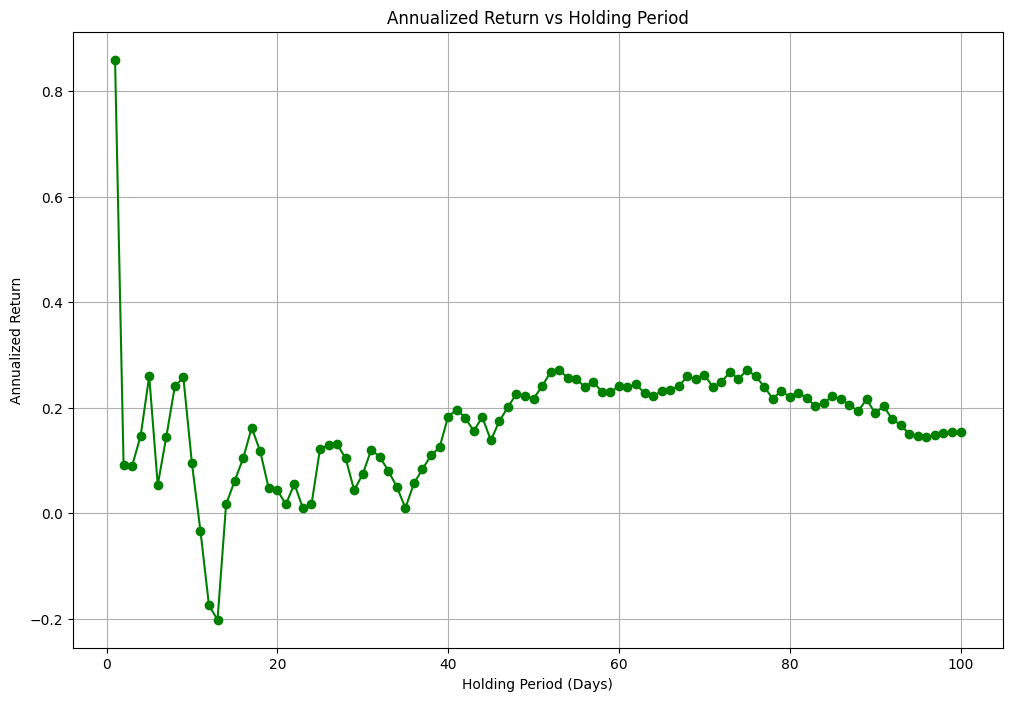

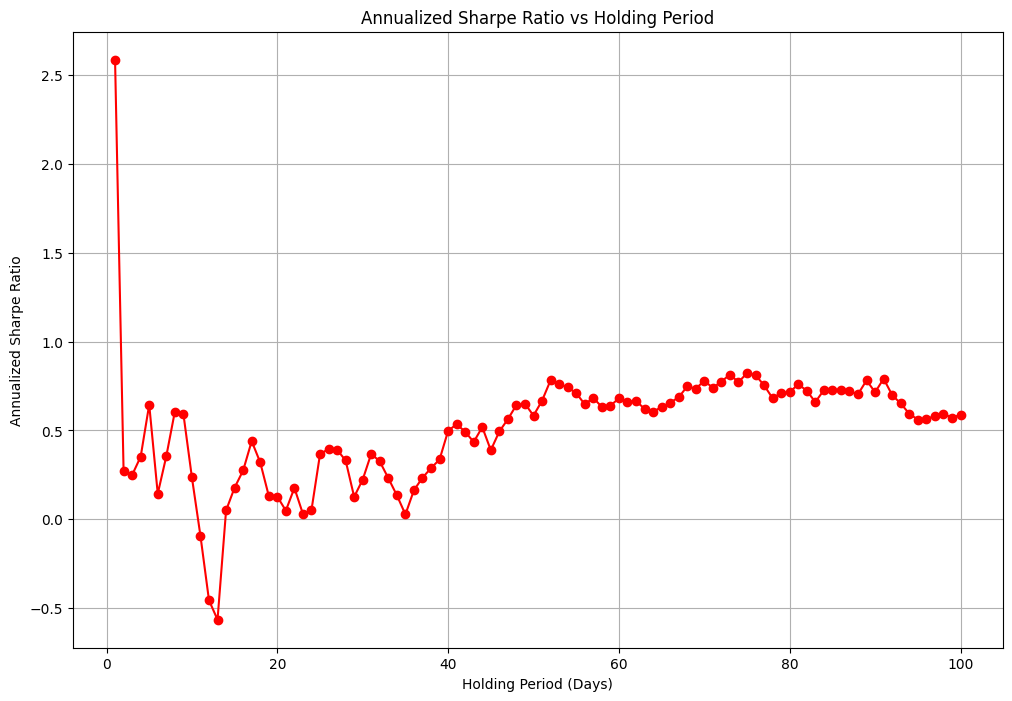

In [70]:

# Combine all data
combined_data = pd.DataFrame()
for ticker, data in aligned_data.items():
    data['Ticker'] = ticker
    combined_data = pd.concat([combined_data, data], axis=0)

# Simulate trades for holding periods from 1 to 100 days
holding_periods = range(1, 101)
results_df = simulate_trade(combined_data, holding_periods)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Average Return'], marker='o')
plt.title('Average Cumulative Return vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Average Cumulative Return')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Sharpe Ratio'], marker='o', color='orange')
plt.title('Sharpe Ratio vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Annualized Return'], marker='o', color='green')
plt.title('Annualized Return vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(results_df['Holding Period'], results_df['Annualized Sharpe Ratio'], marker='o', color='red')
plt.title('Annualized Sharpe Ratio vs Holding Period')
plt.xlabel('Holding Period (Days)')
plt.ylabel('Annualized Sharpe Ratio')
plt.grid(True)
plt.show()




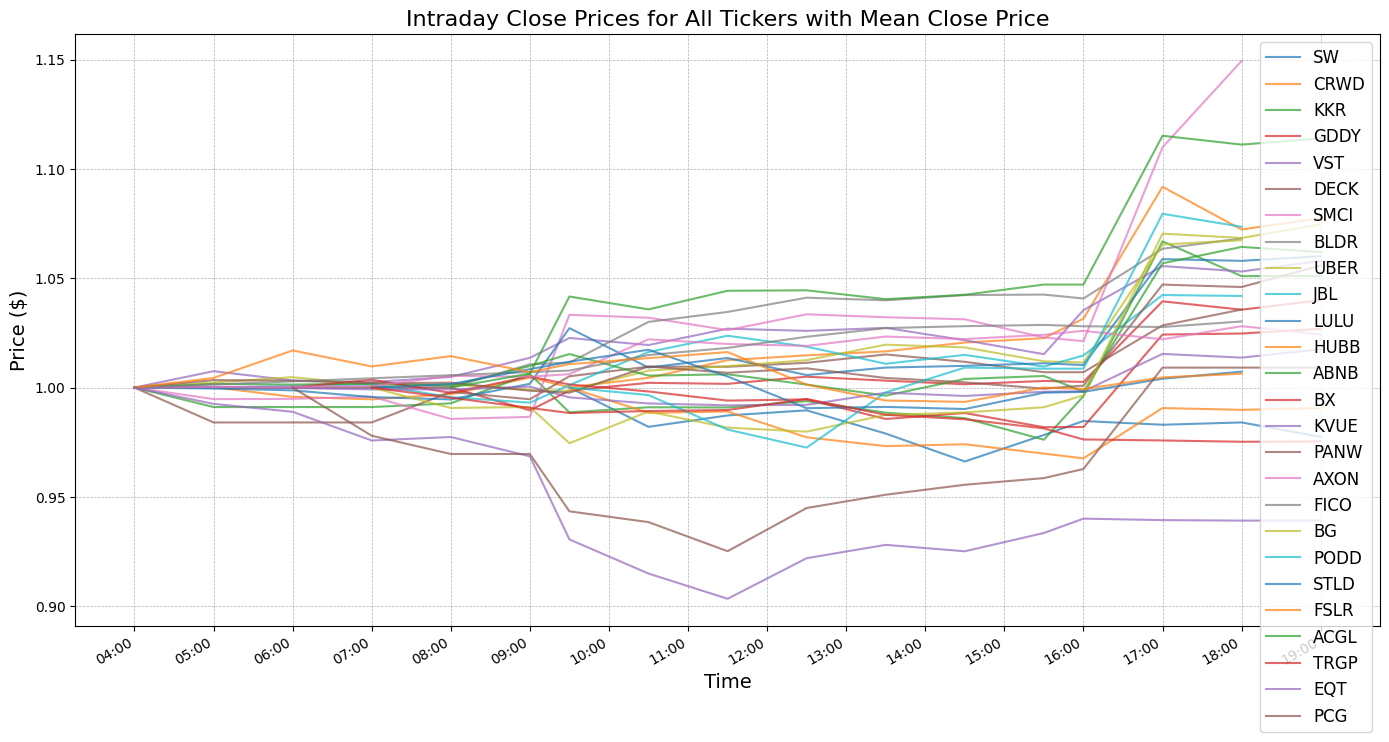

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_all_intraday_close_with_mean(aligned_data_intraday):
    """
    Plots intraday close prices for all tickers on a unified time axis,
    treating data from different days as if they occurred on the same day.
    Also plots the mean close price across all tickers.

    Parameters:
    - aligned_data_intraday (dict): Dictionary where keys are ticker symbols and
      values are pandas DataFrames containing intraday data with at least
      'Datetime' and 'Close' columns.
    """
    valid_tickers = {}
    
    # Validate and filter data first
    for ticker, df in aligned_data_intraday.items():
        if df.empty:
            print(f"No intraday data for {ticker}. Skipping.")
            continue
        
        if 'Datetime' not in df.columns or 'Close' not in df.columns:
            print(f"Required columns ('Datetime' and 'Close') missing for {ticker}. Skipping.")
            continue
        
        # If both 'Datetime' and 'Close' are present, add to valid tickers
        valid_tickers[ticker] = df
    
    if not valid_tickers:
        print("No valid data available to plot after filtering.")
        return

    plt.figure(figsize=(14, 8))
    close_prices = pd.DataFrame()
    
    # Define a common date to assign to all times for consistent plotting
    common_date = pd.Timestamp('1900-01-01')
    
    for ticker, df in valid_tickers.items():
        try:
            # Convert 'Datetime' to datetime objects
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            # Extract time component and assign a common date
            df['Time'] = common_date + pd.to_timedelta(df['Datetime'].dt.time.astype(str))
            # Sort by 'Time' to ensure chronological order
            df = df.sort_values('Time')
        except Exception as e:
            print(f"Error processing 'Datetime' for {ticker}: {e}")
            continue
        
        # Add 'Close' prices to the DataFrame, indexed by 'Time'
        close_prices[ticker] = df.set_index('Time')['Close']
        # Plot 'Close' vs 'Time' for the current ticker
        plt.plot(df['Time'], df['Close']/df['Close'][0], label=ticker, alpha=0.7)
    
    if close_prices.empty:
        print("No data available to plot.")
        return
    
    # Calculate mean close price across tickers for each time point
    mean_close = close_prices.mean(axis=1)
    
    
    # Set plot title and labels
    plt.title('Intraday Close Prices for All Tickers with Mean Close Price', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Price ($)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Format x-axis to display time properly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
    
    plt.tight_layout()
    plt.show()



plot_all_intraday_close_with_mean(aligned_data_intraday)


In [75]:
from scipy import stats

def perform_t_test(returns):
    t_stat, p_value = stats.ttest_1samp(returns, 0)
    # Since we're testing if the mean > 0, adjust p-value for one-tailed test
    p_value /= 2
    return t_stat, p_value

# Apply the t-test on average returns for each holding period
t_test_results = []

for holding_period in holding_periods:
    subset = combined_data[combined_data['Days Since Publish'] >= holding_period]
    returns = []
    for ticker in subset['Ticker'].unique():
        ticker_data = subset[subset['Ticker'] == ticker].reset_index(drop=True)
        if len(ticker_data) >= holding_period:
            start_price = ticker_data['Open'].iloc[0]
            end_price = ticker_data['Close'].iloc[holding_period - 1]
            cumulative_return = (end_price - start_price) / start_price
            returns.append(cumulative_return)
    if len(returns) > 0:
        t_stat, p_val = perform_t_test(returns)
        t_test_results.append({
            'Holding Period': holding_period,
            'T-Statistic': t_stat,
            'P-Value': p_val,
            'Mean Return': np.mean(returns)
        })

t_test_df = pd.DataFrame(t_test_results)

# Display holding periods where p-value < 0.05
significant_results = t_test_df[t_test_df['P-Value'] < 0.05]
print("Significant Holding Periods (p < 0.05):")
print(t_test_df)


c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Significant Holding Periods (p < 0.05):
    Holding Period  T-Statistic   P-Value  Mean Return
0                1     0.943534  0.176032     0.003316
1                2    -0.017144  0.493211    -0.000122
2                3    -0.168533  0.433581    -0.001145
3                4     0.416012  0.340008     0.003927
4                5    -0.304752  0.381206    -0.003297
..             ...          ...       ...          ...
71              72    -0.379229  0.354077    -0.014525
72              73    -0.319034  0.376505    -0.015754
73              74     1.527767  0.085206     0.087758
74              75          NaN       NaN     0.049420
75              76          NaN       NaN     0.063778

[76 rows x 4 columns]
